In [66]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import configparser
import os, copy, random

In [67]:
#grayImg = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/femur_plate_1.jpg", cv2.IMREAD_GRAYSCALE)
#grayImg = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/long_screw.jpg", cv2.IMREAD_GRAYSCALE)
#grayImg = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/surgical_plate_1.jpg", cv2.IMREAD_GRAYSCALE)
#grayImg = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/sugical_plate_2.jpg", cv2.IMREAD_GRAYSCALE)
grayImg = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/surgical_pin_1.jpg", cv2.IMREAD_GRAYSCALE)

config = configparser.ConfigParser()
config.read('config.ini')

base_folder = config['DEFAULT']['base_folder']
xray_folder = config['DEFAULT']['xray_folder']
xray_folder = os.path.join(base_folder, xray_folder)
source_folder = config['DEFAULT']['source_folder']
source_folder = os.path.join(base_folder, source_folder)

if os.path.isdir(base_folder) == False:
    raise exception("base folder name is wrong. check config.ini file")
if os.path.isdir(xray_folder) == False:
    raise exception("xray folder name is wrong. check config.ini file")
if os.path.isdir(source_folder) == False:
    raise exception("source image folder name is wrong. checkl config.ini file")

xray_file_urls = os.listdir(xray_folder)
source_file_urls = os.listdir(source_folder)

In [106]:
Image_information = {
    "image_url": "/home/jongmunchoi/code/FB_synthesizer/X-ray_img/femur1.jpg",
    #"artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/long_screw.jpg",
    #"artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/surgical_pin_1.jpg",
    "artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/femur_plate_1.jpg",
    #"position": [150,50],
    "position": [40,50],
    "mag": [0.15,0.15],
    "rotation": 10,
    "opacity": 1,
    "mask_marker": 1,
    "image": False,
    "mask_layer": False
}

def random_insertion_image(Image_information):
    masked_array = []
    image_url = Image_information["image_url"]
    artifact_url = Image_information["artifact_url"]
    position = Image_information["position"]
    mag = Image_information["mag"]
    rotation = Image_information["rotation"]
    opacity = Image_information["opacity"]
    x_ray = Image_information["image"]
    mask_marker = Image_information["mask_marker"]
    mask_layer = Image_information["mask_layer"]
    original_image = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)
    if hasattr(x_ray, "__len__") == False:
        x_ray = copy.copy(original_image)
    if hasattr(mask_layer, "__len__") == False:    
        mask_layer = np.zeros(x_ray.shape)
    artifact = cv2.imread(artifact_url, cv2.IMREAD_GRAYSCALE)
    #blurring artifact
    kernel = np.ones((5, 5), np.float32)/25 
    artifact_blur = cv2.filter2D(artifact, -1, kernel)
    #artifact_to_binary
    _, artifact_dst = cv2.threshold(artifact_blur, 180, 200, cv2.THRESH_BINARY)
    #artifact_resize
    artifact_resize = cv2.resize(artifact_dst,None,fx=mag[0], fy=mag[1], interpolation = cv2.INTER_CUBIC)
    #artifact_bitwise
    artifact_rev = cv2.bitwise_not(artifact_resize)
    #artifact_rotate
    artifact_rotated = imutils.rotate_bound(artifact_rev, rotation)
    
    #image_insertion
    for idx_y,y in enumerate(artifact_rotated):
        for idx_x,x in enumerate(y):
            Y = idx_y+position[1]
            X = idx_x+position[0]
            if Y >= x_ray.shape[0] or X >= x_ray.shape[1]:
                continue
            if x < 200:
                x = 0
            new_color = x_ray[Y][X] + int(x*0.7)
            masked_array_factor = 0
            if original_image[Y][X] > 150:
                masked_array_factor = 1
                mask_layer[Y][X] = str(mask_marker)
            masked_array.append(masked_array_factor)
            if new_color > 255:
                new_color = 255
            x_ray[Y][X] = new_color
    #plt.imshow(x_ray)
    np_x_ray = np.array(masked_array)
    #print(np_x_ray)
    #print(f'area: {np_x_ray.sum()} {len(np_x_ray)} {np_x_ray.sum()/len(np_x_ray)}')
    if len(np_x_ray) == 0:
        return False, False
    print( "cutb:",np_x_ray.sum(), len(np_x_ray),  np_x_ray.sum()/len(np_x_ray) )
    if np_x_ray.sum()/len(np_x_ray) < 0.4:
        return False, False
    #print()
    #print(np_x_ray.sum(), len(np_x_ray), np_x_ray.sum()/len(np_x_ray))
    #print(Image_information)
    #print()
    
    return x_ray, masked_array
    #plt.imshow(artifact_rotated)
image, masked_image = random_insertion_image(Image_information)

cutb: 8536 15580 0.5478818998716303


In [107]:
def random_information(previous_information):
    img = cv2.imread(previous_information["image_url"], cv2.IMREAD_GRAYSCALE)
    width, height = img.shape
    min_x = int(width*0.1)
    max_x = int(width*0.85)
    min_y = int(height*0.1)
    max_y = int(height*0.85)
    random_x = random.randrange(min_x, max_x)
    random_y = random.randrange(min_y, max_y)
    previous_information["position"] = [random_x, random_y]
    previous_information["mag"] = [random.randrange(5,35)/100,random.randrange(5,35)/100]
    previous_information["rotation"] = random.randrange(0,360)
    previous_information["opacity"] = random.randrange(70,100)/100
    return previous_information


In [108]:
previous_information = {"image_url": "/home/jongmunchoi/code/FB_synthesizer/X-ray_img/femur1.jpg",
                        "artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/femur_plate_1.jpg",
                        "position": [40,50],
                        "mag": [0.15,0.15],
                        "rotation": 10,
                        "opacity": 1,
                        "mask_marker": 1,
                        "mask_layer": False,
                        "image": False
                        }
#previous_information = random_information(previous_information)
#_,_ = random_insertion_image(previous_information)

In [109]:
def random_FB_image_generator(image_url,information, insert_FB = 1):
    information["image_url"] = image_url
    for x in range(insert_FB):
        print(f'try: {x}')
        
        random_artifact = random.choice(source_file_urls)
        random_artifact = os.path.join(source_folder, random_artifact)
        information["artifact_url"]= random_artifact
        while(True):
            information = random_information(information)
            #print(information)
            new_image, new_masked_image = random_insertion_image(information)
            if hasattr(new_image, "__len__"):
                information["image"] = new_image
                information["masked_image"] = new_masked_image
                information["mask_marker"] += 1
                print("------------")
                plt.imshow(new_image)
                plt.show()
                print("------------")
                break
            else:
                print("no image")
                #plt.imshow(new_image)
        
    return information
    

try: 0
cutb: 427 4386 0.09735522115823074
no image
no image
no image
no image
no image
cutb: 358 12604 0.028403681370993337
no image
no image
no image
no image
cutb: 0 833 0.0
no image
cutb: 65 7440 0.008736559139784945
no image
no image
cutb: 0 2943 0.0
no image
no image
cutb: 0 336 0.0
no image
cutb: 1436 1760 0.8159090909090909
------------


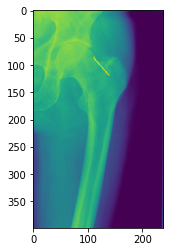

------------
try: 1
cutb: 3022 16790 0.17998808814770698
no image
cutb: 0 551 0.0
no image
cutb: 4043 21736 0.18600478468899523
no image
cutb: 0 2856 0.0
no image
cutb: 0 1512 0.0
no image
no image
cutb: 0 10920 0.0
no image
cutb: 0 8632 0.0
no image
cutb: 0 1248 0.0
no image
cutb: 0 2280 0.0
no image
cutb: 0 2736 0.0
no image
no image
cutb: 1863 4366 0.4267063673843335
------------


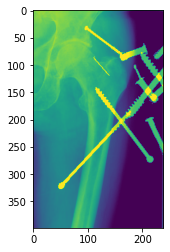

------------


In [110]:
#previous_information["image_url"] = random.choice(xray_folder)
information = {"image": False, "mask_marker": False, "mask_layer": False, "mask_marker": 1}
information = random_FB_image_generator("/home/jongmunchoi/code/FB_synthesizer/X-ray_img/femur1.jpg",information, 2)
#plt.imshow(information["image"])

In [87]:
information.keys()

dict_keys(['image', 'mask_marker', 'mask_layer', 'image_url', 'artifact_url', 'position', 'mag', 'rotation', 'opacity', 'masked_image'])

In [44]:
information["masked_image"]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


try: 0
no image
no image
no image
no image
no image
try: 1
no image
no image
no image
no image
no image


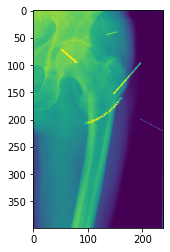

In [63]:
Image_information = {
    "image_url": "/home/jongmunchoi/code/FB_synthesizer/X-ray_img/femur1.jpg",
    #"artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/long_screw.jpg",
    #"artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/surgical_pin_1.jpg",
    "artifact_url": "/home/jongmunchoi/code/FB_synthesizer/source_img/femur_plate_1.jpg",
    #"position": [150,50],
    "position": [40,50],
    "mag": [0.15,0.15],
    "rotation": 10,
    "opacity": 1,
    "mask_marker": 1,
    "image": False,
    "mask_layer": False
}
Image_information = random_FB_image_generator("/home/jongmunchoi/code/FB_synthesizer/X-ray_img/femur1.jpg",Image_information, 2)
i,m = random_insertion_image(Image_information)
plt.imshow(i)